# CEJST Dataset

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os
from us import states
from census import Census
import time
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import zipfile

from pathlib import Path
from dotenv import load_dotenv
import requests
import json
import os
import datetime as dt
from tqdm import trange, tqdm
import UCSmpl

## Retrieve EJScreen data

Unfortunately, this data must downloaded manually due to permissions issues. It may work programmatically on another machine or with an API key, but the easiest thing to do is download the data.

[Data Download](https://www.epa.gov/ejscreen/download-ejscreen-data)

Download the "Geodatabase of National EJScreen Data at the Tract Level"

In [7]:
%%time
data_path = Path("../../spatial-data/EJSCREEN_2023_Tracts_with_AS_CNMI_GU_VI.gdb.zip")
ejscreen_df = gpd.read_file(data_path)

CPU times: total: 4min 26s
Wall time: 4min 29s


In [8]:
ejscreen_df.head()

,ID,STATE_NAME,ST_ABBREV,CNTY_NAME,REGION,ACSTOTPOP,ACSIPOVBAS,ACSEDUCBAS,ACSTOTHH,ACSTOTHU,...,P_D5_PWDIS,AREALAND,AREAWATER,NPL_CNT,TSDF_CNT,EXCEED_COUNT_80,EXCEED_COUNT_80_SUP,Shape_Length,Shape_Area,geometry
0,01001020100,Alabama,AL,Autauga,4,1791.0,1791.0,1225.0,609.0,646.0,...,77.0,9825304.0,28435.0,0.0,0.0,0.0,2.0,0.153800,0.000945,"MULTIPOLYGON (((-86.51038 32.47225, -86.51030 ..."
1,01001020200,Alabama,AL,Autauga,4,2010.0,1766.0,1480.0,600.0,747.0,...,79.0,3320818.0,5669.0,0.0,0.0,5.0,3.0,0.092916,0.000319,"MULTIPOLYGON (((-86.48127 32.47744, -86.48126 ..."
2,01001020300,Alabama,AL,Autauga,4,3577.0,3577.0,2415.0,1346.0,1447.0,...,47.0,5349271.0,9054.0,0.0,0.0,2.0,2.0,0.100499,0.000514,"MULTIPOLYGON (((-86.47087 32.47573, -86.47084 ..."
3,01001020400,Alabama,AL,Autauga,4,3802.0,3802.0,2886.0,1606.0,1669.0,...,26.0,6384282.0,8408.0,0.0,0.0,0.0,2.0,0.117871,0.000613,"MULTIPOLYGON (((-86.45394 32.49318, -86.45372 ..."
4,01001020501,Alabama,AL,Autauga,4,4381.0,4381.0,3000.0,1789.0,1860.0,...,60.0,6203654.0,0.0,0.0,0.0,0.0,2.0,0.109853,0.000595,"MULTIPOLYGON (((-86.43842 32.44973, -86.43838 ..."


In [9]:
_TIGER_URL = "https://www2.census.gov/geo/tiger/"

def get_tiger_files(year, state_abbr, feature='tract'):
    """
    This function retrievs a TIGER shapefile from the United States Census
    website.

    Parameters
    ----------
    year : int
        The shapefile year of interest.
    state_abbr : str
        The abbreviation for the state of interest.
    feature : str, optional
        Indicates which TIGER file data feature to extract, by default 'tract'.
    """
    
    
    try:
        state = states.lookup(state_abbr)
        assert state, f"{state_abbr} is not a state in the U.S."
    except AssertionError as error:
        raise error

    _FEATURE_FILE = {'tract':f'TRACT/tl_{year}_{state.fips}_tract.zip',
                     'county':f"COUNTY/tl_{year}_us_county.zip"}
    data_route = f"TIGER{year}/{_FEATURE_FILE[feature]}"
    
    geo_df = gpd.read_file(_TIGER_URL+data_route)
    
    return geo_df

In [13]:
year = 2019
state_abbr = 'NH'
state = states.lookup(state_abbr)

In [14]:
%time state_df = get_tiger_files(year=year, state_abbr=state_abbr, feature='tract')

CPU times: total: 172 ms
Wall time: 530 ms


In [15]:
us_contiguous = [s.name for s in states.STATES_CONTIGUOUS]
len(us_contiguous)

48

In [16]:
ejscreen_contiguous = ejscreen_df[ejscreen_df['STATE_NAME'].isin(us_contiguous)]

CPU times: total: 14.5 s
Wall time: 15 s


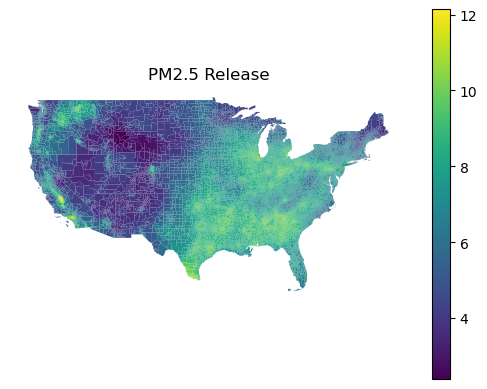

In [17]:
%%time
ejscreen_contiguous.to_crs(epsg=4269).plot(column='PM25', legend=True)
ax = plt.gca()
ax.set_title("PM2.5 Release", fontdict=dict(family="sans serif"))
ax.set_axis_off()

In [19]:
state_cjest = ejscreen_contiguous[ejscreen_contiguous['STATE_NAME'] == state.name].copy()

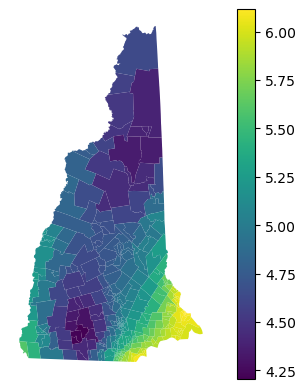

In [21]:
# county_lines = state_cjest.dissolve(by='CF')
state_cjest.to_crs(epsg=4269).plot(column='PM25', cmap='viridis',legend=True)
plt.gca().set_axis_off()